# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. Training an agent with MADDPG

In [6]:
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

from multi_agent import MultiAgent

multi_agent = MultiAgent(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=2)

In [7]:
def maddpg(n_episodes=10000, max_t=1000, print_every=20):
    scores_deque = deque(maxlen=100)
    scores = []
    
    with open("progress.txt", "w") as f: 
        f.write('Starting training at ' + datetime.now().ctime() + '\n\n') 
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]         # reset the environment
        states = env_info.vector_observations
        multi_agent.reset()
        curr_scores = np.zeros(num_agents)

        for t in range(max_t):
            actions = multi_agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            multi_agent.step(states, actions, rewards, next_states, dones)

            curr_scores += np.max(rewards)
            states = next_states
            if np.any(dones):
                break

        score = np.max(curr_scores)
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.3f}\tScore: {:.3f}\t'.format(i_episode, np.mean(scores_deque), score), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tScore: {:.3f}'.format(i_episode, np.mean(scores_deque), score))

        if np.mean(scores_deque)>=checkpoints[0]:
            checkpoint_status = '\rCheckpoint for average score {:.2f} after {:d} episodes!'.format(np.mean(scores_deque), i_episode-100)
            print(checkpoint_status)
            with open("progress.txt", "a") as f: 
                f.write(checkpoint_status+'\n') 
            torch.save(multi_agent.agents[0].actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(multi_agent.agents[1].actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(multi_agent.agents[0].critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(multi_agent.agents[1].critic_local.state_dict(), 'checkpoint_critic_1.pth')

            checkpoints.pop(0)
            if not len(checkpoints):
                with open("progress.txt", "a") as f:  
                    f.write('\n\nCompleted training at ' + datetime.now().ctime())                 
                break

    return scores

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

Checkpoint for average score 0.10 after -99 episodes!
Episode 20	Average Score: 0.005	Score: 0.000	
Episode 40	Average Score: 0.003	Score: 0.000	
Episode 60	Average Score: 0.002	Score: 0.000	
Episode 80	Average Score: 0.001	Score: 0.000	
Episode 100	Average Score: 0.001	Score: 0.000	
Episode 120	Average Score: 0.000	Score: 0.000	
Episode 140	Average Score: 0.000	Score: 0.000	
Episode 160	Average Score: 0.000	Score: 0.000	
Episode 180	Average Score: 0.000	Score: 0.000	
Episode 200	Average Score: 0.001	Score: 0.000	
Episode 220	Average Score: 0.004	Score: 0.000	
Episode 240	Average Score: 0.004	Score: 0.000	
Episode 260	Average Score: 0.004	Score: 0.000	
Episode 280	Average Score: 0.004	Score: 0.000	
Episode 300	Average Score: 0.003	Score: 0.000	
Episode 320	Average Score: 0.004	Score: 0.100	
Episode 340	Average Score: 0.010	Score: 0.000	
Episode 360	Average Score: 0.018	Score: 0.100	
Episode 380	Average Score: 0.027	Score: 0.000	
Episode 400	Average Score: 0.036	Score: 0.100	
Episode 42

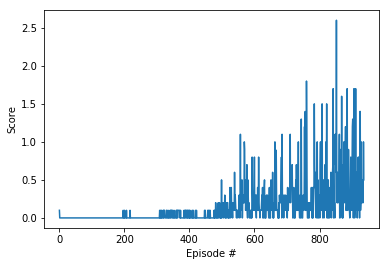

In [8]:
target_score = 0.5

# five checkpoints to store models - last one is the target score
checkpoints = list(np.linspace(0,target_score,6))[1:]

scores = maddpg()
plot_scores(scores)


In [9]:
import pickle

with open('scores', 'wb') as fp:
    pickle.dump(scores, fp)